In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

import tensorflow as tf
from setup_mnist import MNIST
from setup_cifar import CIFAR
import os

def train(data, file_name, params, num_epochs=50, batch_size=128, train_temp=1, init=None):
    """
    Standard neural network training procedure.
    """
    model = Sequential()

    print(data.train_data.shape)
    
    model.add(Conv2D(params[0], (3, 3),
                            input_shape=data.train_data.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(params[1], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(params[2], (3, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(params[3], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(params[4]))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(params[5]))
    model.add(Activation('relu'))
    model.add(Dense(10))
    
    if init != None:
        model.load_weights(init)

    def fn(correct, predicted):
        return tf.nn.softmax_cross_entropy_with_logits(labels=correct,
                                                       logits=predicted/train_temp)

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    model.compile(loss=fn,
                  optimizer=sgd,
                  metrics=['accuracy'])
    
    model.fit(data.train_data, data.train_labels,
              batch_size=batch_size,
              validation_data=(data.validation_data, data.validation_labels),
              nb_epoch=num_epochs,
              shuffle=True)
    

    if file_name != None:
        model.save(file_name)

    return model

def train_distillation(data, file_name, params, num_epochs=50, batch_size=128, train_temp=1):
    """
    Train a network using defensive distillation.
    Distillation as a Defense to Adversarial Perturbations against Deep Neural Networks
    Nicolas Papernot, Patrick McDaniel, Xi Wu, Somesh Jha, Ananthram Swami
    IEEE S&P, 2016.
    """
    if not os.path.exists(file_name+"_init"):
        # Train for one epoch to get a good starting point.
        train(data, file_name+"_init", params, 1, batch_size)
    
    # now train the teacher at the given temperature
    teacher = train(data, file_name+"_teacher", params, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # evaluate the labels at temperature t
    predicted = teacher.predict(data.train_data)
    with tf.Session() as sess:
        y = sess.run(tf.nn.softmax(predicted/train_temp))
        print(y)
        data.train_labels = y

    # train the student model at temperature t
    student = train(data, file_name, params, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # and finally we predict at temperature 1
    predicted = student.predict(data.train_data)

    print(predicted)

/home/tianwei/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
if not os.path.isdir('models'):
    os.makedirs('models')

# train(CIFAR(), "models/cifar", [64, 64, 128, 128, 256, 256], num_epochs=50)
train(MNIST(), "models/mnist", [32, 32, 64, 64, 200, 200], num_epochs=50)

train_distillation(MNIST(), "models/mnist-distilled-100", [32, 32, 64, 64, 200, 200],
                   num_epochs=50, train_temp=100)
# train_distillation(CIFAR(), "models/cifar-distilled-100", [64, 64, 128, 128, 256, 256],
#                    num_epochs=50, train_temp=100)

(55000, 28, 28, 1)


/home/tianwei/anaconda3/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 4s 75us/step - loss: 0.6842 - acc: 0.7719 - val_loss: 0.0860 - val_acc: 0.9740
Epoch 2/50
55000/55000 [==============================] - 4s 74us/step - loss: 0.1227 - acc: 0.9626 - val_loss: 0.0608 - val_acc: 0.9824
Epoch 3/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0869 - acc: 0.9734 - val_loss: 0.0484 - val_acc: 0.9870
Epoch 4/50
55000/55000 [==============================] - 4s 72us/step - loss: 0.0719 - acc: 0.9784 - val_loss: 0.0487 - val_acc: 0.9860
Epoch 5/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0614 - acc: 0.9825 - val_loss: 0.0426 - val_acc: 0.9884
Epoch 6/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0530 - acc: 0.9842 - val_loss: 0.0370 - val_acc: 0.9904
Epoch 7/50
55000/55000 [==============================] - 4s 71us/step - loss: 0.0464 - acc: 0.9851 - val_loss: 0.0379 - val_acc:

55000/55000 [==============================] - 4s 70us/step - loss: 0.0450 - acc: 0.9859 - val_loss: 0.0414 - val_acc: 0.9892
Epoch 13/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0405 - acc: 0.9875 - val_loss: 0.0420 - val_acc: 0.9896
Epoch 14/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0391 - acc: 0.9881 - val_loss: 0.0416 - val_acc: 0.9906
Epoch 15/50
55000/55000 [==============================] - 4s 74us/step - loss: 0.0375 - acc: 0.9883 - val_loss: 0.0417 - val_acc: 0.9892
Epoch 16/50
55000/55000 [==============================] - 4s 75us/step - loss: 0.0357 - acc: 0.9887 - val_loss: 0.0389 - val_acc: 0.9894
Epoch 17/50
55000/55000 [==============================] - 4s 75us/step - loss: 0.0344 - acc: 0.9893 - val_loss: 0.0425 - val_acc: 0.9892
Epoch 18/50
55000/55000 [==============================] - 4s 73us/step - loss: 0.0323 - acc: 0.9899 - val_loss: 0.0393 - val_acc: 0.9894
Epoch 19/50
55000/55000 [=====================

In [2]:
import tensorflow as tf
import numpy as np
import time

from setup_cifar import CIFAR, CIFARModel
from setup_mnist import MNIST, MNISTModel
from setup_inception import ImageNet, InceptionModel

from l2_attack import CarliniL2
from l0_attack import CarliniL0
from li_attack import CarliniLi


# def show(img):
#     """
#     Show MNSIT digits in the console.
#     """
#     remap = "  .*#"+"#"*100
#     img = (img.flatten()+.5)*3
#     if len(img) != 784: return
#     print("START")
#     for i in range(28):
#         print("".join([remap[int(round(x))] for x in img[i*28:i*28+28]]))


def generate_data(data, samples, targeted=True, start=0, inception=False):
    """
    Generate the input data to the attack algorithm.
    data: the images to attack
    samples: number of samples to use
    targeted: if true, construct targeted attacks, otherwise untargeted attacks
    start: offset into data to use
    inception: if targeted and inception, randomly sample 100 targets intead of 1000
    """
    inputs = []
    targets = []
    for i in range(samples):
        if targeted:
            if inception:
                seq = random.sample(range(1,1001), 10)
            else:
                seq = range(data.test_labels.shape[1])

            for j in seq:
                if (j == np.argmax(data.test_labels[start+i])) and (inception == False):
                    continue
                inputs.append(data.test_data[start+i])
                targets.append(np.eye(data.test_labels.shape[1])[j])
        else:
            inputs.append(data.test_data[start+i])
            targets.append(data.test_labels[start+i])

    inputs = np.array(inputs)
    targets = np.array(targets)

    return inputs, targets

In [3]:
# sess = tf.Session()
# tf.global_variables_initializer().run()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
# sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

data, model =  MNIST(), MNISTModel("models/mnist", sess)
attack = CarliniLi(sess, model,  max_iterations=1000)
# attack = CarliniL2(sess, model, batch_size=9, max_iterations=1000, confidence=0)

inputs, targets = generate_data(data, samples=1, targeted=True,
                                start=0, inception=False)

In [4]:
print(inputs.shape )
print(targets )

(9, 28, 28, 1)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [5]:
timestart = time.time()
adv = attack.attack(inputs, targets)
timeend = time.time()

print("Took",timeend-timestart,"seconds to run",len(inputs),"samples.")

try const 1e-05
0 (0.00038407883, 38.407883, 0.0)
100 (0.00030171848, 30.171848, 0.0)
200 (0.00019788143, 19.788143, 0.0)
300 (0.00014708823, 14.708823, 0.0)
400 (7.119765e-05, 7.1197658, 0.0)
500 (3.1585787e-05, 3.1585789, 0.0)
600 (1.8241271e-05, 1.8241272, 0.0)
700 (1.04356e-05, 1.04356, 0.0)
800 (4.459654e-06, 0.4459654, 0.0)
Tau 0.96663
try const 1e-05
0 (0.8857781, 0.0, 0.8857781)
100 (0.037443817, 0.0, 0.037443817)
Tau 0.868191
try const 1e-05
0 (1.8299592, 0.0, 1.8299592)
100 (5.0241956e-06, 0.5024196, 0.0)
Tau 0.7796291
try const 1e-05
0 (2.0781434, 0.0, 2.0781434)
100 (0.057950668, 1.0542684, 0.057940125)
200 (7.725262e-07, 0.07725263, 0.0)
Tau 0.70067066
try const 1e-05
0 (2.4280846, 0.0, 2.4280846)
100 (0.10089892, 1.4542227, 0.10088438)
200 (9.917276e-06, 0.9917276, 0.0)
300 (6.6237926e-06, 0.66237926, 0.0)
400 (5.2099203e-06, 0.52099204, 0.0)
500 (4.596691e-06, 0.4596691, 0.0)
600 (4.114468e-06, 0.4114468, 0.0)
700 (3.42643e-06, 0.34264302, 0.0)
800 (2.6843952e-06, 0.2684

100 (0.0047488566, 0.17927551, 0.0010772943)
200 (0.0025899867, 0.12610912, 7.2717667e-06)
300 (0.0014132194, 0.040673733, 0.0005802214)
400 (6.6257955e-05, 0.0008225441, 4.941225e-05)
Tau 0.1919182777404785
try const 0.02048
0 (3.017057, 0.0, 3.017057)
100 (0.08518131, 4.1543922, 9.936094e-05)
200 (0.06387902, 3.10105, 0.000369519)
300 (0.061234362, 2.9680803, 0.00044807792)
400 (0.060939286, 2.9670892, 0.0001733005)
500 (0.061503056, 2.8829682, 0.0024598688)
600 (0.05727034, 2.7589293, 0.0007674694)
700 (0.05498275, 2.663197, 0.00044047832)
800 (0.053159527, 2.575431, 0.00041469932)
900 (0.05420716, 2.6251764, 0.00044354796)
try const 0.04096
0 (0.10547939, 2.5629394, 0.0005013943)
100 (0.09384691, 2.2526946, 0.0015765429)
200 (0.08858753, 2.1245399, 0.0015663803)
300 (0.086415365, 2.072029, 0.0015450567)
400 (0.08459943, 2.0166454, 0.0019976348)
500 (0.08342919, 1.9733434, 0.0026010424)
600 (0.079928756, 1.9333358, 0.0007393211)
700 (0.07951643, 1.9037538, 0.001538679)
800 (0.078779

300 (0.07185397, 1.6337347, 0.07080838)
400 (0.02774976, 0.90428734, 0.027171016)
Tau 0.30483848
try const 0.00064
0 (1.6050309, 0.0, 1.6050309)
100 (0.049279694, 2.768734, 0.047507703)
200 (0.048968084, 2.425458, 0.047415793)
300 (0.048399135, 1.5136108, 0.047430426)
400 (0.020818602, 0.82474947, 0.020290762)
500 (0.00020541747, 0.3209648, 0.0)
Tau 0.27384204
try const 0.00064
0 (1.7514946, 0.0, 1.7514946)
100 (0.0031812426, 3.1449966, 0.0011684448)
200 (0.001871456, 2.9241502, 0.0)
300 (0.0017313496, 2.7052338, 0.0)
400 (0.0014845863, 2.3196661, 0.0)
500 (0.0010961931, 1.6950834, 1.1339784e-05)
600 (0.00072767393, 1.1369905, 0.0)
700 (0.00050935167, 0.79586196, 0.0)
800 (0.0002639662, 0.4124472, 0.0)
900 (0.000103350525, 0.1614852, 0.0)
Tau 0.24635439
try const 0.00064
0 (2.0787241, 0.0, 2.0787241)
100 (0.04003277, 3.8632624, 0.037560284)
200 (0.034236234, 3.7442138, 0.031839937)
300 (0.0248409, 3.6093552, 0.022530913)
400 (0.016533626, 3.3842838, 0.014367685)
500 (0.002018789, 3.154

100 (0.06126349, 3.0795956, 0.0612019)
200 (0.005517787, 3.0759106, 0.005456269)
300 (6.111021e-05, 3.0555105, 0.0)
400 (6.0716055e-05, 3.0358028, 0.0)
500 (5.9835053e-05, 2.9917526, 0.0)
600 (5.970701e-05, 2.9853506, 0.0)
700 (5.9578113e-05, 2.9789057, 0.0)
800 (5.9470196e-05, 2.9735098, 0.0)
900 (5.9291553e-05, 2.9645777, 0.0)
try const 4e-05
0 (0.00011821323, 2.9553308, 0.0)
100 (0.000117266536, 2.9316635, 0.0)
200 (0.00011666454, 2.9166136, 0.0)
300 (0.00011619365, 2.9048414, 0.0)
400 (0.00011568909, 2.8922272, 0.0)
500 (0.00011517402, 2.8793507, 0.0)
600 (0.000114628296, 2.8657074, 0.0)
700 (0.000114059294, 2.8514824, 0.0)
800 (0.00011343891, 2.8359728, 0.0)
900 (0.000112830196, 2.820755, 0.0)
try const 8e-05
0 (0.0002242993, 2.8037415, 0.0)
100 (0.00022167762, 2.7709703, 0.0)
200 (0.00021878006, 2.7347507, 0.0)
300 (0.00021574654, 2.6968317, 0.0)
400 (0.00021251815, 2.656477, 0.0)
500 (0.00020880706, 2.6100883, 0.0)
600 (0.00020441978, 2.5552473, 0.0)
700 (0.00020030746, 2.503843

try const 0.32768
0 (0.20244871, 0.6019764, 0.0051930845)
100 (0.12631115, 0.02805996, 0.117116466)
200 (0.116619006, 0.0, 0.116619006)
300 (0.10935345, 0.008133888, 0.10668814)
400 (0.11043666, 0.018659592, 0.104322284)
500 (0.11117762, 0.0, 0.11117762)
600 (0.10086531, 0.00182724, 0.10026656)
700 (0.10425255, 0.0, 0.10425255)
800 (0.09797299, 0.0, 0.09797299)
900 (0.09896732, 0.014619827, 0.094176695)
try const 0.65536
0 (0.09834277, 0.007843018, 0.09320277)
100 (0.10252069, 0.0, 0.10252069)
200 (0.11262576, 0.018465996, 0.10052389)
300 (0.099469215, 0.0, 0.099469215)
400 (0.10308352, 0.011167526, 0.09576477)
500 (0.11189758, 0.030094147, 0.09217508)
600 (0.08643657, 0.0, 0.08643657)
700 (0.08985154, 0.004473686, 0.086919665)
800 (0.088767976, 0.0, 0.088767976)
900 (0.09061955, 0.0, 0.09061955)
try const 1.31072
0 (0.102307364, 0.0, 0.102307364)
100 (0.100510255, 0.0, 0.100510255)
200 (0.090556726, 0.0, 0.090556726)
300 (0.09308697, 0.0, 0.09308697)
400 (0.095352426, 0.0, 0.095352426

700 (0.0016987721, 0.25697422, 0.00038306415)
800 (0.0008468718, 0.13608837, 0.0001500994)
900 (0.0009118896, 0.17810345, 0.0)
try const 0.01024
0 (0.0019070898, 0.18623924, 0.0)
Tau 0.15629486739635468
try const 0.01024
0 (1.6271482, 0.0, 1.6271482)
100 (0.07008949, 4.5781174, 0.023209572)
200 (0.053381346, 3.9076777, 0.013366729)
300 (0.04933401, 3.8549032, 0.0098598)
400 (0.046344988, 3.8784428, 0.006629735)
500 (0.03977481, 3.8356628, 0.0004976243)
600 (0.03910887, 3.8133087, 6.058812e-05)
700 (0.03991056, 3.695695, 0.002066642)
800 (0.038678013, 3.7399435, 0.0003809929)
900 (0.038500782, 3.7295055, 0.0003106445)
try const 0.02048
0 (0.07776751, 3.7851667, 0.00024729967)
100 (0.07282842, 3.4936113, 0.0012792647)
200 (0.071586065, 3.4747095, 0.00042401254)
300 (0.07104113, 3.426897, 0.0008582771)
400 (0.0699165, 3.354354, 0.0012193322)
500 (0.07286192, 3.3456678, 0.0043426454)
600 (0.070464626, 3.39052, 0.0010267794)
700 (0.069780014, 3.3638887, 0.00088757277)
800 (0.06944973, 3.346

300 (0.07121514, 1.3762376, 0.070334345)
400 (0.043539573, 0.9618993, 0.042923957)
500 (0.00045233534, 0.706774, 0.0)
600 (0.00017916183, 0.27994037, 0.0)
700 (2.4321746e-05, 0.03800273, 0.0)
Tau 0.4131244
try const 0.00064
0 (1.9050235, 0.0, 1.9050235)
100 (0.078783676, 1.956224, 0.077531695)
200 (0.04165144, 1.5990965, 0.040628016)
300 (0.040453915, 1.0563116, 0.039777875)
400 (0.024643928, 0.6098292, 0.024253637)
500 (0.0001934584, 0.30227876, 0.0)
600 (7.728439e-05, 0.120756865, 0.0)
700 (1.9105224e-05, 0.029851913, 0.0)
800 (4.6493528e-07, 0.0007264614, 0.0)
Tau 0.37102473
try const 0.00064
0 (1.9332789, 0.0, 1.9332789)
100 (0.03846307, 2.613967, 0.036790133)
200 (0.016438792, 2.1978903, 0.015032142)
300 (0.014727377, 0.9285178, 0.014133126)
400 (0.00043500427, 0.6796942, 0.0)
500 (0.0002785713, 0.4352677, 0.0)
600 (0.00021436934, 0.33495212, 0.0)
700 (0.00019301558, 0.30158687, 0.0)
800 (0.00011645584, 0.18196225, 0.0)
900 (3.862671e-05, 0.060354233, 0.0)
Tau 0.3333321
try const 

300 (1.4548664e-05, 1.4548664, 0.0)
400 (8.942909e-06, 0.8942909, 0.0)
500 (4.1730973e-06, 0.41730976, 0.0)
600 (3.5532282e-06, 0.35532284, 0.0)
700 (3.3938215e-06, 0.33938217, 0.0)
800 (3.2416724e-06, 0.32416725, 0.0)
900 (3.0816268e-06, 0.3081627, 0.0)
try const 2e-05
0 (5.8504866e-06, 0.29252434, 0.0)
100 (5.3954886e-06, 0.26977444, 0.0)
200 (4.940948e-06, 0.24704742, 0.0)
300 (4.467468e-06, 0.22337341, 0.0)
400 (3.8697813e-06, 0.19348907, 0.0)
500 (3.3271979e-06, 0.1663599, 0.0)
600 (2.7814865e-06, 0.13907433, 0.0)
700 (2.2144698e-06, 0.110723495, 0.0)
800 (1.6153526e-06, 0.08076763, 0.0)
900 (9.9514e-07, 0.049757004, 0.0)
try const 4e-05
0 (6.685257e-07, 0.016713142, 0.0)
Tau 0.43397534
try const 4e-05
0 (1.5435085, 0.0, 1.5435085)
100 (0.04599842, 5.1832833, 0.04579109)
200 (0.021378692, 5.222773, 0.021169782)
300 (0.00020691624, 5.1729064, 0.0)
400 (0.00020548294, 5.1370735, 0.0)
500 (0.0002043838, 5.1095953, 0.0)
600 (0.00020318519, 5.07963, 0.0)
700 (0.00020190427, 5.047607, 0

400 (0.10049681, 0.0, 0.10049681)
500 (0.09607675, 0.017299652, 0.090408)
600 (0.09144367, 0.0, 0.09144367)
700 (0.09348564, 0.0, 0.09348564)
800 (0.0898048, 0.0, 0.0898048)
900 (0.09611446, 0.0, 0.09611446)
try const 0.65536
0 (0.09605473, 0.0, 0.09605473)
100 (0.10338555, 0.0, 0.10338555)
200 (0.108346105, 0.03231716, 0.08716673)
300 (0.09763755, 0.0, 0.09763755)
400 (0.11912921, 0.0, 0.11912921)
500 (0.09136635, 0.0, 0.09136635)
600 (0.08640137, 0.0, 0.08640137)
700 (0.0931786, 0.0, 0.0931786)
800 (0.102035776, 0.0, 0.102035776)
900 (0.08516432, 0.0, 0.08516432)
try const 1.31072
0 (0.09630158, 0.010560036, 0.08246033)
100 (0.115035966, 0.0, 0.115035966)
200 (0.115707085, 0.0, 0.115707085)
300 (0.11417024, 0.0, 0.11417024)
400 (0.118254095, 0.0, 0.118254095)
500 (0.12126233, 0.0, 0.12126233)
600 (0.0993229, 0.0, 0.0993229)
700 (0.095812425, 0.0, 0.095812425)
800 (0.110458344, 0.0, 0.110458344)
900 (0.114093766, 0.0, 0.114093766)
try const 2.62144
0 (0.10729651, 0.0, 0.10729651)
100 

100 (0.057668395, 2.7525477, 0.029482305)
200 (0.045184195, 1.5378872, 0.02943623)
300 (0.038389135, 0.9450935, 0.028711379)
400 (0.024910528, 0.73014414, 0.017433852)
500 (0.0067870594, 0.66279876, 0.0)
600 (0.006201062, 0.60557246, 0.0)
700 (0.0056568957, 0.5524312, 0.0)
800 (0.004965718, 0.48481992, 1.1622906e-06)
900 (0.004909028, 0.47939727, 0.0)
try const 0.02048
0 (0.009070714, 0.43905407, 7.888675e-05)
100 (0.007709327, 0.376432, 0.0)
200 (0.0065367203, 0.31241935, 0.00013837218)
300 (0.0053338315, 0.25851578, 3.9428473e-05)
400 (0.0040908814, 0.1979078, 3.772974e-05)
500 (0.0024029322, 0.11733067, 0.0)
600 (0.0010573856, 0.04619938, 0.00011122227)
700 (0.0, 0.0, 0.0)
Tau 0.25931266
try const 0.02048
0 (2.9698403, 0.0, 2.9698403)
100 (0.08573045, 2.3810494, 0.036966562)
200 (0.03217075, 1.3537388, 0.0044461787)
300 (0.023194594, 1.0388517, 0.0019189119)
400 (0.018654278, 0.91085345, 0.0)
500 (0.01586808, 0.76439893, 0.00021319091)
600 (0.015159317, 0.73469317, 0.00011280179)
70

100 (0.09465171, 3.2353413, 0.093616396)
200 (0.026632054, 2.9866986, 0.02567631)
300 (0.024648365, 2.8394055, 0.023739755)
400 (0.000869675, 2.7177346, 0.0)
500 (0.0003970523, 1.2407885, 0.0)
600 (3.3906403e-05, 0.10595751, 0.0)
Tau 0.39522004
try const 0.00032
0 (2.1073582, 0.0, 2.1073582)
100 (0.034283843, 3.600107, 0.033131808)
200 (0.021731248, 3.154453, 0.020721823)
300 (0.020816907, 2.4821174, 0.02002263)
400 (0.00061141374, 1.9106679, 0.0)
500 (0.00054012844, 1.6879015, 0.0)
600 (0.00035524124, 1.1101289, 0.0)
Tau 0.35431546
try const 0.00032
0 (1.8302746, 0.0, 1.8302746)
100 (0.03944825, 3.9985962, 0.0381687)
200 (0.038951423, 2.808855, 0.03805259)
300 (0.036779318, 1.9355845, 0.036159933)
400 (0.0013994402, 1.7576313, 0.0008369982)
500 (0.00020676086, 0.6461277, 0.0)
Tau 0.31642145
try const 0.00032
0 (1.9027215, 0.0, 1.9027215)
100 (0.024181556, 4.548056, 0.022726178)
200 (0.0012942612, 4.044566, 0.0)
300 (0.001008768, 3.1524, 0.0)
400 (0.0006643547, 2.0761085, 0.0)
500 (0.0

100 (0.322199, 0.0, 0.322199)
200 (0.33028978, 0.0, 0.33028978)
300 (0.30779842, 0.0, 0.30779842)
400 (0.45745, 0.0, 0.45745)
500 (0.44286117, 0.0, 0.44286117)
600 (0.41578722, 0.0, 0.41578722)
700 (0.3104751, 0.0, 0.3104751)
800 (0.33252412, 0.0, 0.33252412)
900 (0.26121634, 0.0, 0.26121634)
try const 10.48576
0 (0.3263399, 0.0, 0.3263399)
100 (0.6365039, 0.0, 0.6365039)
200 (0.757883, 0.0, 0.757883)
300 (0.48899087, 0.0, 0.48899087)
400 (0.4441505, 0.0, 0.4441505)
500 (0.6442035, 0.0, 0.6442035)
600 (0.42786455, 0.0, 0.42786455)
700 (0.48493087, 0.0, 0.48493087)
800 (0.55085576, 0.0, 0.55085576)
900 (0.4073313, 0.0, 0.4073313)
try const 1e-05
0 (0.00031185884, 31.185884, 0.0)
100 (0.00024778792, 24.778793, 0.0)
200 (0.00015289945, 15.289946, 0.0)
300 (4.5496563e-05, 4.5496564, 0.0)
Tau 0.8079605
try const 1e-05
0 (0.14255404, 0.0, 0.14255404)
Tau 0.7249559
try const 1e-05
0 (0.6308322, 0.0, 0.6308322)
Tau 0.64882374
try const 1e-05
0 (0.9704354, 0.0, 0.9704354)
Tau 0.5813597
try cons

100 (0.08208534, 1.9595747, 0.0018211603)
200 (0.07919739, 1.8931875, 0.0016524345)
300 (0.079113126, 1.8647261, 0.0027339458)
400 (0.07743458, 1.8470879, 0.0017778575)
500 (0.07762871, 1.8227615, 0.0029684007)
600 (0.07705418, 1.8369532, 0.0018125772)
700 (0.07602089, 1.79597, 0.0024579614)
800 (0.07623419, 1.8011684, 0.002458334)
900 (0.07424882, 1.7903557, 0.00091585517)
try const 0.08192
0 (0.14743653, 1.7877312, 0.0009855926)
100 (0.13872734, 1.635004, 0.0047878027)
200 (0.13799568, 1.6281681, 0.0046161413)
300 (0.13767117, 1.6187925, 0.0050596893)
400 (0.13637346, 1.6109419, 0.004405111)
500 (0.13592874, 1.6010561, 0.0047702193)
600 (0.13569018, 1.5971031, 0.0048554987)
700 (0.13293807, 1.5909624, 0.0026064366)
800 (0.13226235, 1.5918398, 0.0018588305)
900 (0.13275595, 1.5764055, 0.0036168098)
try const 0.16384
0 (0.25837374, 1.5556965, 0.0034884363)
100 (0.25236225, 1.4682236, 0.0118085295)
200 (0.25199246, 1.4683275, 0.01142168)
300 (0.24917924, 1.4650183, 0.009150654)
400 (0.2

In [6]:
%matplotlib inline
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt

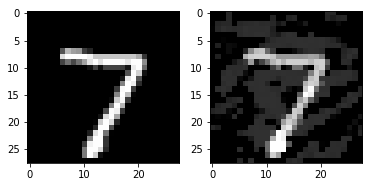

Score: [ 5.170768   -1.4041042   5.127113    2.2518997  -4.5322003  -1.5442501
 -5.308185    5.170317    1.9339355  -0.79562396]
output:  0
Total distortion: 3.421368008335542


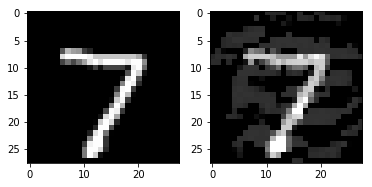

Score: [-1.7774701   3.3198128  -0.50948566  0.89509314 -0.06836628  1.6908567
 -1.8874415   3.313888   -0.3552428  -1.0093849 ]
output:  1
Total distortion: 3.4015591019914413


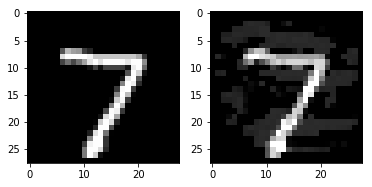

Score: [ 0.27141464 -0.43407804 12.046028    0.8326565  -1.449984   -4.7235875
 -7.2832346  12.041189   -0.916164   -3.2898908 ]
output:  2
Total distortion: 2.6483528776349914


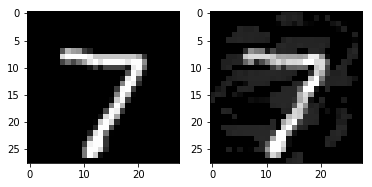

Score: [-5.4824615   0.59569657 -2.870981   13.129155   -3.3729274   3.6360555
 -8.083505   13.119049   -1.5625515   1.6628952 ]
output:  3
Total distortion: 2.5131731109074407


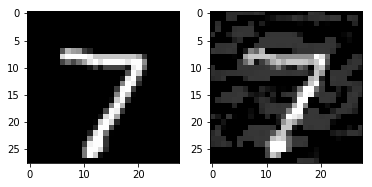

Score: [-2.1669686   1.2056794   0.29313198  1.8550038   1.8702562  -0.5760833
 -1.4211308   1.8652472   0.25362688  0.10553035]
output:  4
Total distortion: 3.8477945525587995


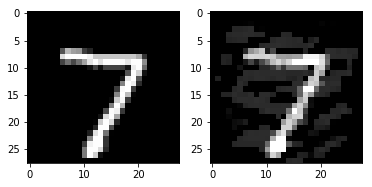

Score: [-2.8183904  -0.42242986 -4.1250076   7.720789   -3.4945526   8.159966
 -6.492681    8.127405   -0.41944236  3.8905616 ]
output:  5
Total distortion: 2.7418218732999424


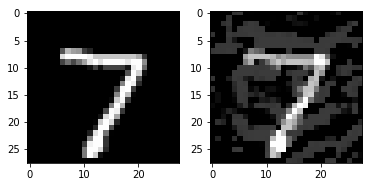

Score: [-0.16341227  0.5414668   0.1126424   0.32714882 -0.10207804  0.5391848
  0.54561263  0.53433067  0.53510016 -0.81691986]
output:  6
Total distortion: 4.195615278005737


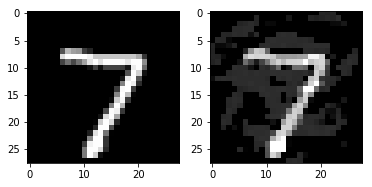

Score: [-1.4503995  -0.69764364  0.50874674  4.924043   -3.097374    1.50923
 -5.4629793   4.902893    4.9326816   2.0705729 ]
output:  8
Total distortion: 3.0351680328258257


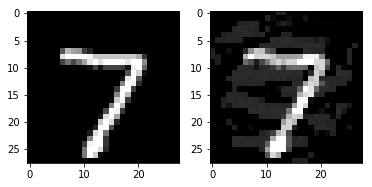

Score: [-4.1930795  -0.97076625 -2.8818438   8.064635   -1.8237972   3.726974
 -8.350328    9.276434   -0.3799647   9.283927  ]
output:  9
Total distortion: 2.7399881351520348


In [7]:


for org_img, adv_img in zip(inputs, adv):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(np.reshape(org_img, (28,28)), cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(adv_img, (28,28)), cmap="gray")
#     plt.colorbar()
    plt.show()
    pred_score = model.model.predict(adv_img.reshape( (1,adv_img.shape[0],adv_img.shape[1],adv_img.shape[2] )))
    print("Score:",pred_score[0])
    print('output: ', np.argmax(pred_score[0]) )
    print("Total distortion:", np.sum((adv_img-org_img)**2)**.5)
    
#     break

In [ ]:
# for i in range(len(adv)):
#     print("Valid:")
#     show(inputs[i])
#     print("Adversarial:")
#     show(adv[i])

#     print("Classification:", model.model.predict(adv[i:i+1]))

#     print("Total distortion:", np.sum((adv[i]-inputs[i])**2)**.5)